In [1]:
from sklearn.metrics import f1_score as f1
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import auc
import skimage.io as io
import pandas as pd
import scipy.stats as stats
import scipy as sp
from scipy import ndimage
import os
import sys
from sklearn.metrics import mean_squared_log_error
import numpy as np
import pandas as pd
import tensorflow
import xarray as xr
import seaborn as sns
from unet import UNet
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
sns.set()

In [2]:
path_main = r'Z:\vovam\Vova\outputs\2021-06-13\09-56-13'
result_p = os.path.join(path_main,'results')
os.chdir(path_main)

In [3]:
def load_data(src):
    channels_src = 'channels.txt'
    with open(os.path.join(src, channels_src)) as f:
        channels = f.read().splitlines()

    mat = np.loadtxt(os.path.join(src, 'mat.txt')).astype(np.float32)
    mat = (mat / np.linalg.norm(mat, ord=1, axis=0))
    return mat, channels

In [4]:
model = UNet(in_channels=8, out_channels=25)
device = 'cpu'

resume_path = os.path.join(path_main, 'x_hat/cp.pt')

checkpoint = torch.load(resume_path, map_location='cpu')  # , map_location=lambda storage, loc: storage)

model.load_state_dict(checkpoint["model"])

optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer.load_state_dict(checkpoint["optimizer"])

model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [5]:
src = r'Z:\vovam\Vova\data\matrices\8_25'
mat, channels = load_data(src)

In [6]:
x = xr.load_dataarray(r'C:\Users\leeatgen.WISMAIN\Desktop\Vova\all_data.nc').sel(fovs='Point5', channels=channels).values.astype(np.float32)

In [7]:
A = torch.tensor(mat, requires_grad=False).unsqueeze(-1).unsqueeze(-1).float().to(device)
X = torch.tensor(x.astype(np.float32), requires_grad=False).to(device)
if X.ndim != 4:
    X = X.reshape((1, *X.shape))
Y = F.conv2d(X, A).to(device)

In [8]:
#y = Y[:,:,768:1280,768:1280]
y = Y[:,:,:,:]
_, x_hat = model(y)

In [9]:
def get_scores(p_true, p_hat, point_name, channels):
    ch_range = len(channels)
    f1scores = np.zeros([1, ch_range])
    rmsescores = np.zeros([1, ch_range])
    falsepositive = np.zeros([1, ch_range])
    falsenegative = np.zeros([1, ch_range])
    rmsle = np.zeros([1, ch_range])

    for i, chname in enumerate(channels):
        #true_data = p_true.sel(fovs=[point_name], channels=chname)
        #true_data = p_true[i, 768:1280, 768:1280].squeeze().flatten()  # delete when you check full size pics and not crops
        true_data = p_true[i, :, :].squeeze().flatten()

        hat_data = p_hat[i, :, :].squeeze().flatten()
        hat_data = np.rint(hat_data)
        hat_data = hat_data.clip(min=0)

        binary_true = 1 * (true_data > 0)
        binary_hat = 1 * (hat_data > 0)

        falsepositive[0, i] = sum((binary_hat - binary_true) == 1) / len(binary_hat)
        falsenegative[0, i] = sum((binary_hat - binary_true) == -1) / len(binary_hat)
        # f1scores[0, i] = f1(binary_true, binary_hat)
        f1scores[0, i] = 2 * (binary_true * binary_hat).sum() / (binary_true.sum() + binary_hat.sum())
        rmsescores[0, i] = mse(true_data, hat_data, squared=False) / np.linalg.norm(true_data, ord=None, axis=None,
                                                                                    keepdims=False)
        rmsle[0, i] = mean_squared_log_error(true_data, hat_data)

    return f1scores, rmsescores, falsepositive, falsenegative, rmsle


def save_pics(data, prefix, channels, path):
    for i, chname in enumerate(channels):
        pic_data = data[i, :, :].squeeze().flatten()
        pic_data = np.rint(pic_data)
        pic_data = pic_data.clip(min=0)
        pic_name = '{}_00{}_{}.tif'.format(prefix, i, chname)
        # change here accordingly to the dimensions of your crop
        #io.imsave(os.path.join(path, pic_name), pic_data.reshape((512, 512)), check_contrast=False)
        io.imsave(os.path.join(path, pic_name), pic_data.reshape((2048, 2048)), check_contrast=False)
        
def combine_everyting(p_true, p_dat, channels, pic_prefix, path, pics=True):
    
    if not os.path.isdir(path):
            os.mkdir(path)
            print('Directory for results is created')
    else:
            print('There is a directory for results')
            
    if pics:
        pic_path = os.path.join(path, 'pictures')
        if not os.path.isdir(pic_path):
            os.mkdir(pic_path)
            print('Directory for pics is created')
        else:
            print('There is a directory for pics')
        save_pics(p_dat, pic_prefix, channels, pic_path)

    scores = get_scores(p_true, p_dat, 'Point5', channels)
    scores_df = pd.DataFrame(
        {'F1': scores[0][0], 'RMSE': scores[1][0], 'RMSLE': scores[4][0], 'FalsePos': scores[2][0],
         'FalseNeg': scores[3][0]}, index=channels)
    scores_df.to_csv(os.path.join(path, 'scores.csv'), index=True)

    f = plt.figure()
    f.set_figheight(20)
    f.set_figwidth(30)
    ax = f.add_subplot(311)
    ax2 = f.add_subplot(312)
    ax3 = f.add_subplot(313)

    scores_df.loc[:, ['FalsePos', 'FalseNeg']].plot.box(ax=ax3)

    ax.bar(channels, scores[0][0])

    ax2.scatter(range(1, 26), sorted(list(scores[0][0])))
    ax2.set_xlabel('Channels in f1 ascending order')
    ax2.set_ylabel('F1 score')
    ys = scores[0][0]
    ax2.set_title('computed AUC using sklearn.metrics.auc: {}'.format(auc(range(1, 26), ys)))

    f.savefig(os.path.join(path, 'plots.pdf'))

There is a directory for results
Directory for pics is created


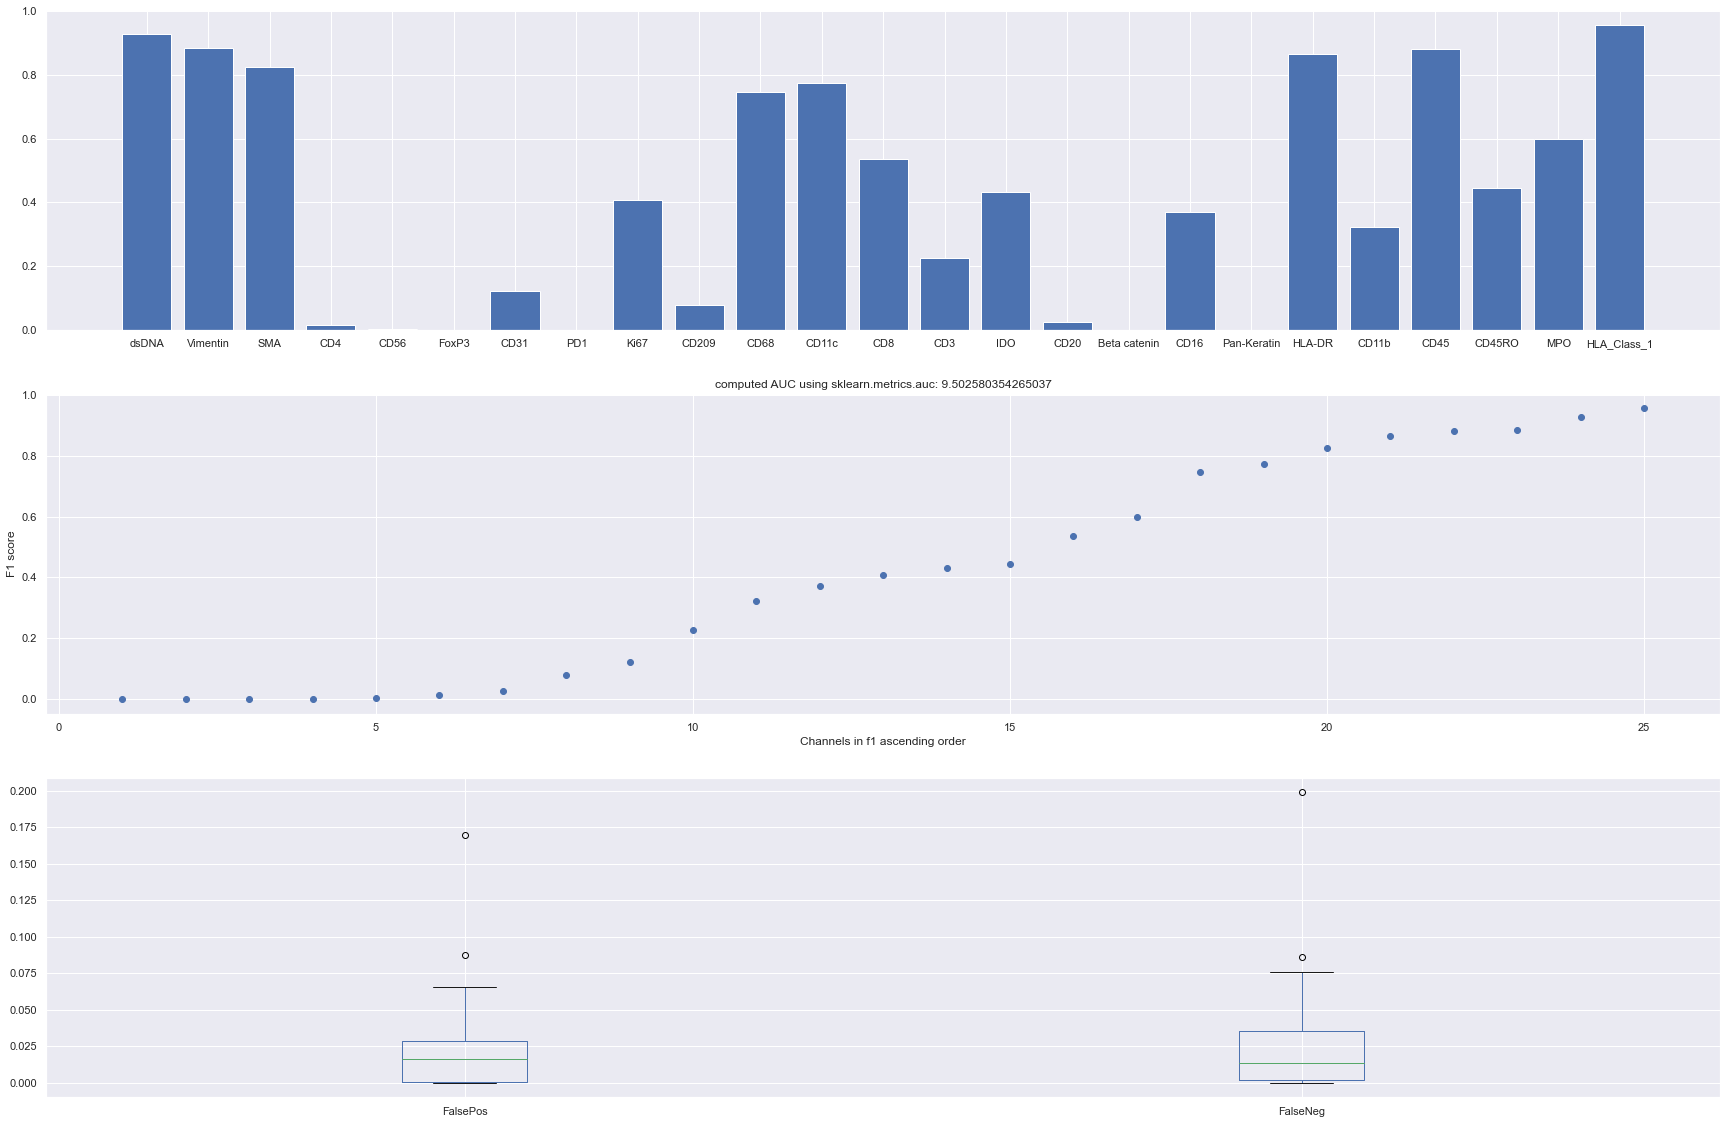

In [10]:
#path =r'C:\Users\leeatgen.WISMAIN\Desktop\Vova\Leeat Keren\8_25epxeriments\dip experiments\augumentations\rotations and crops from crops reg 0 con 0'
hat = x_hat.detach().numpy().squeeze()
result_p = r'C:\Users\leeatgen.WISMAIN\Desktop\Vova\Leeat Keren\8_25epxeriments\dip experiments\CustomDataset_experiments\nocrop_rc512_bs10'
combine_everyting(x, hat, channels,'128_15_r_c',result_p)